<a href="https://colab.research.google.com/github/tanisha019/Predictive-Maintenance-with-Machine-Learning/blob/main/Predictive_Maintenance_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sources

Common data sources for predictive maintenance problems are :

* **Failure history:** The failure history of a machine or component within the machine.
* **Maintenance history:** The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
* **Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.
* **Machine features:** The features of a machine, e.g. engine size, make and model, location.
* **Operator features:** The features of the operator, e.g. gender, past experience
The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [3]:
import pandas as pd

telemetry = pd.read_csv('/content/PdM_telemetry.csv')
errors = pd.read_csv('/content/PdM_errors.csv')
maint = pd.read_csv('/content/PdM_maint.csv')
failures = pd.read_csv('/content/PdM_failures.csv')
machines = pd.read_csv('/content/PdM_machines.csv')

In [4]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())
telemetry.describe()

Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


#### **Telemetry**
The first data source is the telemetry time-series data which consists of **voltage, rotation, pressure, and vibration** measurements collected from 100 machines in **real time averaged over every hour collected during the year 2015**. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

Text(0.5, 0, 'Date')

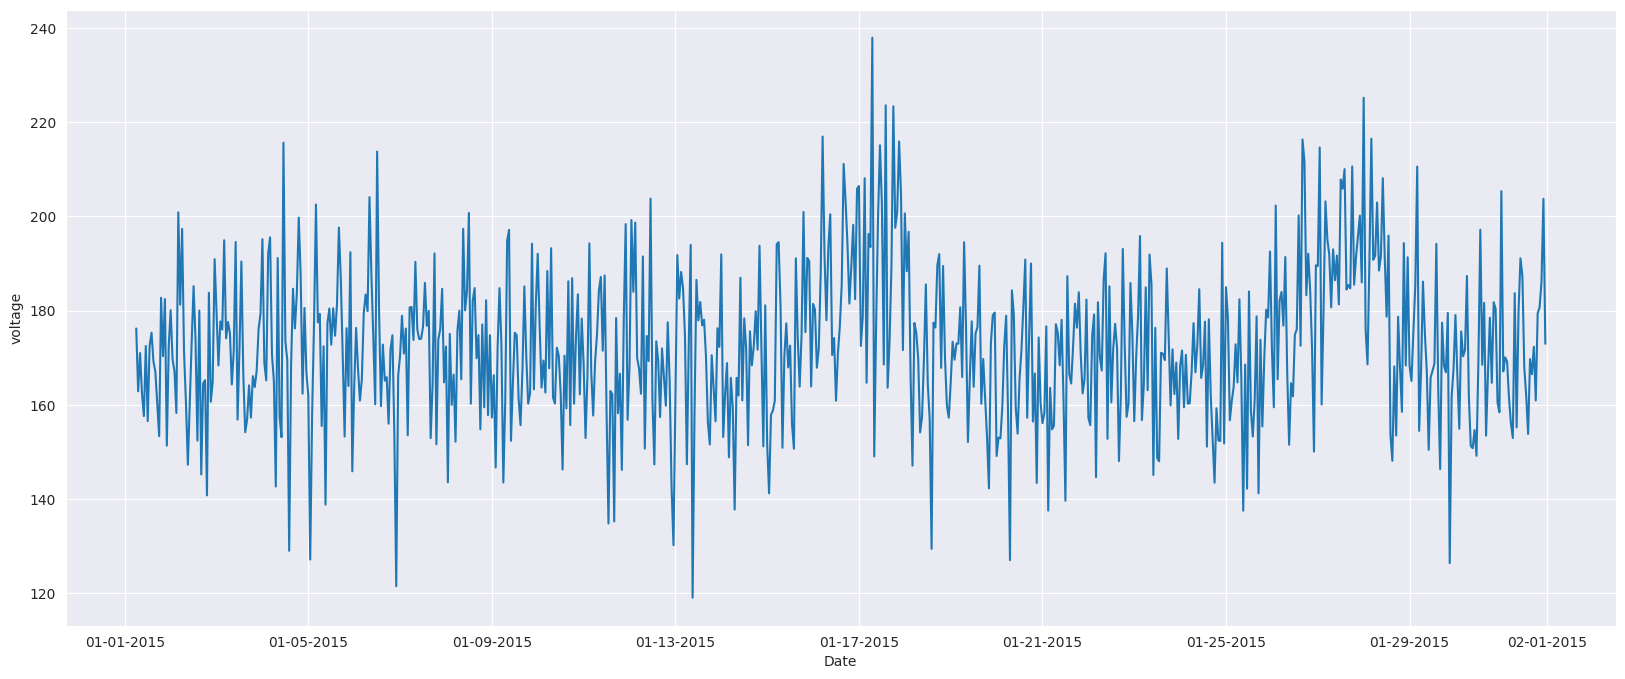

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] <pd.to_datetime('2015-02-01')),
                        ['datetime','volt']]
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d-%Y'
plt.xlabel('Date')

#### **Errors**
The second major data source is the error logs. These are **non-breaking errors thrown while the machine is still operational and do not constitute as failures.** The **error date and times** are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [6]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
errors.head()

Total Number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


,count
errorID,
error1,1010
error2,988
error3,838
error4,727
error5,356


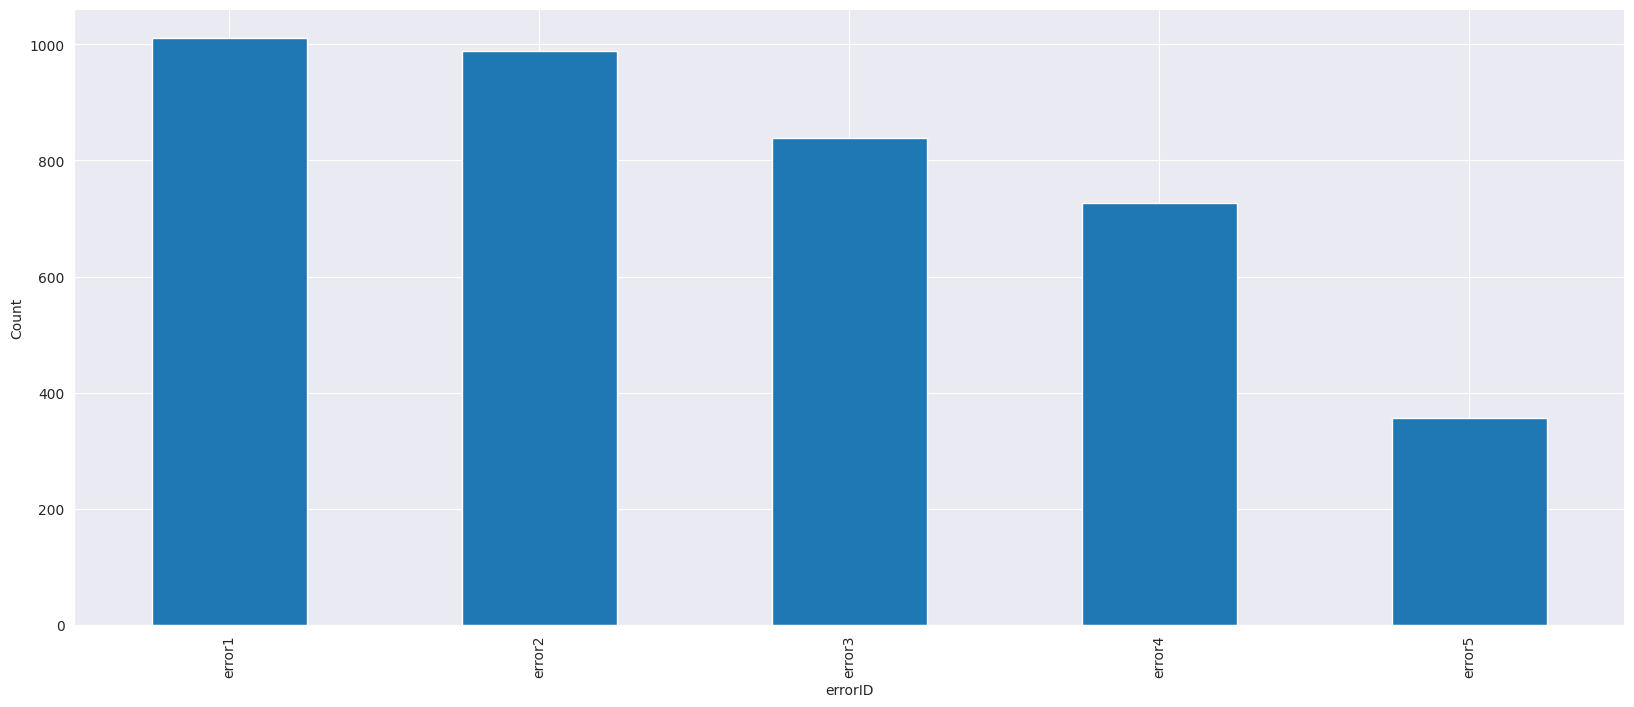

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')
errors['errorID'].value_counts()

#### **Maintenance**
These are the **scheduled and unscheduled** maintenance records which correspond to both **regular inspection of components as well as failures.** A **record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown.** The **records that are created due to breakdowns will be called failures** which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [8]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
maint.head()

Total Number of maintenance Records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


,count
comp,
comp2,863
comp4,811
comp3,808
comp1,804


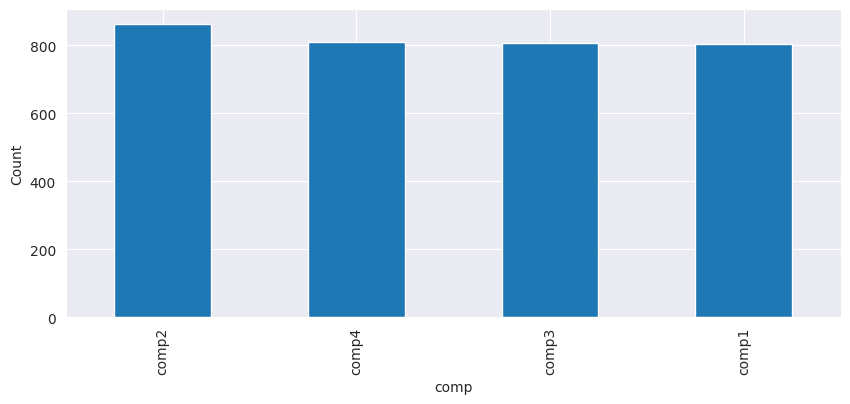

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')
maint['comp'].value_counts()

#### **Machines**
This data set includes some information about the machines: model type and age (years in service).

In [10]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


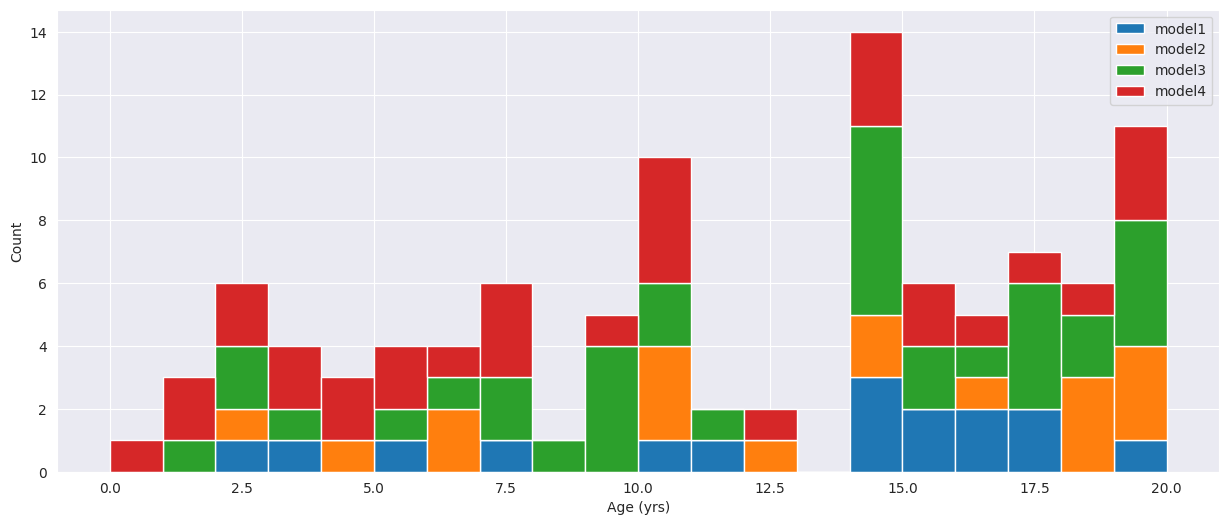

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

#### **Failures**
These are the records of component replacements **due to failures.** Each record has a **date and time, machine ID, and failed component type.**

In [12]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


,count
failure,
comp2,259
comp1,192
comp4,179
comp3,131


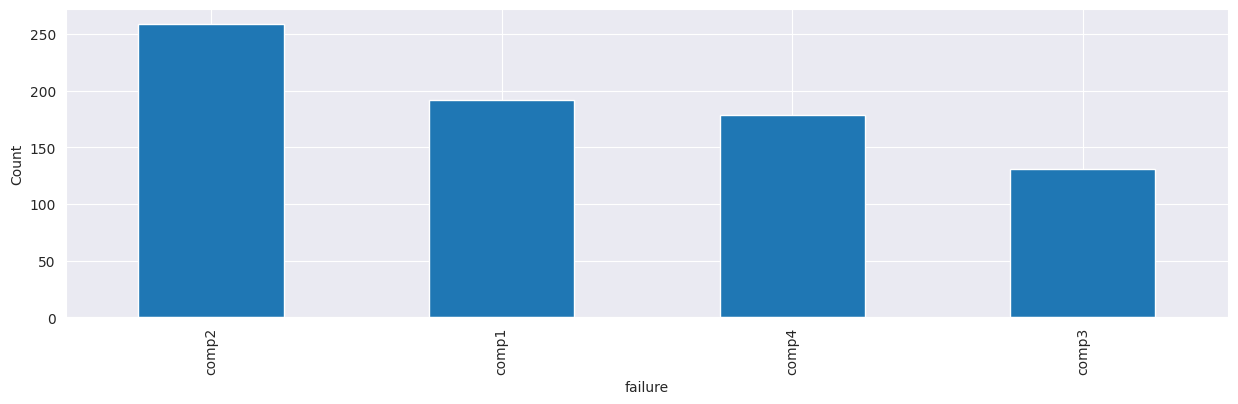

In [13]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

## Feature Engineering
The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### Lag Features from Telemetry
Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [17]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

/tmp/ipython-input-894391920.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-894391920.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-894391920.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-894391920.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())


In [19]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

/tmp/ipython-input-1369356118.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-1369356118.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-1369356118.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-1369356118.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H', closed='left', label='right').mean().unstack())
/tmp/ipython-input-1369356118.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resampl

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542



For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [23]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(
        pd.pivot_table(
            telemetry,
            index='datetime',
            columns='machineID',
            values=col
        )
        .rolling(window=24).mean()
        .resample('3H', closed='left', label='right')
        .first()
        .unstack()
    )
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(
        pd.pivot_table(
            telemetry,
            index='datetime',
            columns='machineID',
            values=col
        )
        .rolling(window=24).std()
        .resample('3H', closed='left', label='right')
        .first()
        .unstack()
    )
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(10)

/tmp/ipython-input-365665573.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-365665573.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-365665573.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-365665573.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-365665573.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-365665573.py:33: FutureWarning: 'H' is deprecated and will be removed i

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214
12,1,2015-01-02 21:00:00,170.556674,452.267095,98.065860,40.033247
13,1,2015-01-03 00:00:00,168.460525,451.031783,99.273286,38.903462
14,1,2015-01-03 03:00:00,169.772951,447.502464,99.005946,39.389725
15,1,2015-01-03 06:00:00,170.900562,453.864597,100.877342,38.696225
16,1,2015-01-03 09:00:00,169.533156,454.785072,100.050567,39.449734


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [26]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6],
    telemetry_mean_24h.iloc[:, 2:6],
    telemetry_sd_24h.iloc[:, 2:6]
], axis=1).dropna()

telemetry_feat.describe()


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,290601.000000,290601,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,2015-07-02 22:00:42.478862848,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,170.775661,446.609874,100.857574,40.383881,14.919452,49.950788,10.046380,5.002089
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.000000,2015-04-03 00:00:00,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,168.072275,441.542561,98.669734,39.354077,13.359069,44.669022,8.924165,4.460675
50%,50.000000,2015-07-02 21:00:00,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,170.212704,449.206885,100.099533,40.072618,14.854186,49.617459,9.921332,4.958793
75%,75.000000,2015-10-01 15:00:00,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,172.462228,456.366349,101.613047,40.833112,16.395372,54.826993,10.980250,5.484430
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783
std,28.798424,NaN,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,4.720237,18.070458,4.737293,2.058059,2.261097,7.684305,1.713206,0.799599


In [27]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129


### Lag Features from Errors
Like telemetry data, errors come with timestamps. An important difference is that the **error IDs are categorical values** and **should not be averaged over time intervals like the telemetry measurements.** Instead, we count the number of errors of each type in a **lagging window. We begin by reformatting the error data** to have one entry per machine per time at which at least one error occurred:

In [28]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
...,...,...,...
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3


In [29]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(13)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,True,False,False,False,False
1,2015-01-03 20:00:00,1,False,False,True,False,False
2,2015-01-04 06:00:00,1,False,False,False,False,True
3,2015-01-10 15:00:00,1,False,False,False,True,False
4,2015-01-22 10:00:00,1,False,False,False,True,False
5,2015-01-25 15:00:00,1,False,False,False,True,False
6,2015-01-27 04:00:00,1,True,False,False,False,False
7,2015-03-03 22:00:00,1,False,True,False,False,False
8,2015-03-05 06:00:00,1,True,False,False,False,False
9,2015-03-20 18:00:00,1,True,False,False,False,False


In [30]:
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [31]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,datetime,machineID,error1,error2,error3,error4,error5
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015-07-02 18:00:00,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015-10-02 00:00:00,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016-01-01 06:00:00,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154


Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:

In [33]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(
    pd.pivot_table(
        error_count,
        index='datetime',
        columns='machineID',
        values=col
    )
    .rolling(window=24).sum()
    .resample('3H', closed='left', label='right')
    .first()
    .unstack()
)

error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

/tmp/ipython-input-2612640388.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-2612640388.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-2612640388.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-2612640388.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')
/tmp/ipython-input-2612640388.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('3H', closed='left', label='right')


,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,2015-07-03 07:30:00,0.027649,0.027069,0.022907,0.019904,0.009753
min,1.00000,2015-01-02 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,2.000000,2.000000,2.000000,2.000000,2.000000
std,28.86612,NaN,0.166273,0.164429,0.151453,0.140820,0.098797


In [34]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


### Days Since Last Replacement from Maintenance
A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

In [35]:
import numpy as np

# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']

    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')

comp_rep.describe()

/tmp/ipython-input-3603977975.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
['2014-12-13 06:00:00', '2015-01-05 06:00:00', '2015-01-20 06:00:00',
 '2015-03-06 06:00:00', '2015-03-21 06:00:00', '2015-06-19 06:00:00',
 '2015-07-19 06:00:00', '2015-08-03 06:00:00', '2015-09-02 06:00:00',
 '2015-10-02 06:00:00',
 ...
 '2014-09-14 06:00:00', '2015-02-12 06:00:00', '2015-03-14 06:00:00',
 '2015-03-29 06:00:00', '2015-04-13 06:00:00', '2015-04-28 06:00:00',
 '2015-07-27 06:00:00', '2015-09-10 06:00:00', '2015-09-25 06:00:00',
 '2015-10-10 06:00:00']
Length: 804, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
/tmp/ipython-input-3603977975.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [36]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
365,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
465,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
565,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
665,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
765,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


## Machine Features
The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [37]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,100,2015-10-05 09:00:00,188.267556,407.256175,108.931184,36.553233,9.599915,40.722980,1.639521,5.724500,171.826650,441.278667,98.311919,39.196175,16.429023,62.147934,7.475540,5.448962
291396,100,2015-10-05 12:00:00,167.859576,465.992407,107.953155,42.708899,14.190347,92.277799,9.577243,0.735339,174.657123,444.147310,98.520388,38.820190,17.019808,64.730136,8.961444,5.833191
291397,100,2015-10-05 15:00:00,170.348099,434.234744,104.514343,38.607950,10.232598,49.524471,12.445345,2.596743,173.787879,448.842085,100.028549,39.375067,17.096392,64.718132,9.420879,5.738756
291398,100,2015-10-05 18:00:00,152.265370,459.557611,103.536524,40.718426,6.758667,27.051145,12.824247,2.752883,172.496791,442.086577,100.361794,38.943434,15.119775,65.929509,8.836617,6.139142


In [38]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head())
final_feat.describe()

   machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error2count  error3count  error4coun

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,290601.000000,290601,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,...,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,2015-07-02 22:00:42.478862848,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,...,0.027560,0.027058,0.022846,0.019955,0.009780,53.382610,51.256589,52.536687,53.679601,11.345226
min,1.000000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2015-04-03 00:00:00,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,7.000000
50%,50.000000,2015-07-02 21:00:00,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,2015-10-01 15:00:00,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,65.875000,67.125000,70.250000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.798424,NaN,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,...,0.166026,0.164401,0.151266,0.140998,0.098931,62.478424,59.156008,58.822946,59.658975,5.826345


# Label Construction
When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "Â€Âœnormal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [41]:
# add 'none' as a valid category
labeled_features['failure'] = labeled_features['failure'].cat.add_categories(['none'])

# fill missing values with 'none'
labeled_features['failure'] = labeled_features['failure'].fillna('none')

labeled_features.head()



,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [42]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
17,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,1.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
18,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,1.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
19,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,1.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
20,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,1.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4
21,1,2015-01-04 21:00:00,190.325814,422.692565,107.393234,49.552856,8.390777,7.176553,4.262645,7.598552,...,1.0,0.0,1.0,22.625,217.625,157.625,172.625,model3,18,comp4
22,1,2015-01-05 00:00:00,169.985134,458.929418,91.494362,54.882021,9.451483,12.052752,3.685906,6.621183,...,0.0,0.0,1.0,22.750,217.750,157.750,172.750,model3,18,comp4
23,1,2015-01-05 03:00:00,149.082619,412.180336,93.509785,54.386079,19.075952,30.715081,3.090266,6.530610,...,0.0,0.0,1.0,22.875,217.875,157.875,172.875,model3,18,comp4
24,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,0.0,0.0,1.0,0.000,218.000,158.000,0.000,model3,18,comp4
1337,1,2015-06-18 09:00:00,169.324639,453.923471,101.313249,53.092274,28.155693,42.557599,7.688674,2.488851,...,0.0,0.0,1.0,89.125,29.125,14.125,134.125,model3,18,comp4
1338,1,2015-06-18 12:00:00,190.691297,441.577271,97.192512,44.025425,6.296827,47.271008,7.577957,4.648336,...,0.0,0.0,1.0,89.250,29.250,14.250,134.250,model3,18,comp4


# Modelling
After the feature engineering and labelling steps, either Azure Machine Learning Studio or this notebook can be used to create a predictive model. The recommend Azure Machine Learning Studio experiment can be found in the Cortana Intelligence Gallery: Predictive Maintenance Modelling Guide Experiment. Below, we describe the modelling process and provide an example Python model.

# Training, Validation and Testing
When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is effected by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# make test and training splits
threshold_dates = [
    [pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
    [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
    [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]
]

test_results = []
models = []

for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(
        labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime', 'machineID', 'failure'], axis=1)
    )
    test_X = pd.get_dummies(
        labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime', 'machineID', 'failure'], axis=1)
    )

    # align train and test so they have the same dummy columns
    train_X, test_X = train_X.align(test_X, join='left', axis=1, fill_value=0)

    # train and predict using the model, storing results for later
    my_model = GradientBoostingClassifier(random_state=42)
    my_model.fit(train_X, train_y)

    test_result = labeled_features.loc[labeled_features['datetime'] > first_test_date].copy()
    test_result['predicted_failure'] = my_model.predict(test_X)

    test_results.append(test_result)
    models.append(my_model)


KeyboardInterrupt: 

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# get feature importances from first model
importances = models[0].feature_importances_
labels = test_X.columns

# sort by importance
labels, importances = zip(*sorted(zip(labels, importances), key=lambda x: x[1], reverse=True))

# plot
plt.bar(range(len(importances)), importances, tick_label=labels)
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importances (GradientBoosting)')
plt.tight_layout()
plt.show()


IndexError: list index out of range

<Figure size 1000x600 with 0 Axes>

# Evaluation
In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The comparison will bring out the value and benefits of using a machine learning model better.

In the following, we use an evaluation function that computes many important evaluation metrics along with baseline metrics for classification problems. For a detailed explanation of the metrics, please refer to the scikit-learn documentation and a companion blog post (with examples in R, not Python),

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []

    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])

    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])

    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)

    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])

    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])

    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])


    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])

    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels

    return output_df

In [ ]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only